In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as impg

%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [133]:
camera_cal_img_paths = list(map(lambda path: './camera_cal/' + path.split('\\')[-1] ,
                     glob.glob('./camera_cal/*.jpg')))
test_img_paths = list(map(lambda path: './test_images/' + path.split('\\')[-1],
                          glob.glob('./test_images/*.jpg')))
challenge_clip = VideoFileClip("./challenge_video.mp4")
harder_clip = VideoFileClip("./harder_challenge_video.mp4")

In [3]:
camera_cal_img_paths.sort(key = lambda x: 11 * len(x) + int(x[-5]))

In [134]:
num_flames = np.int(challenge_clip.fps * challenge_clip.duration)

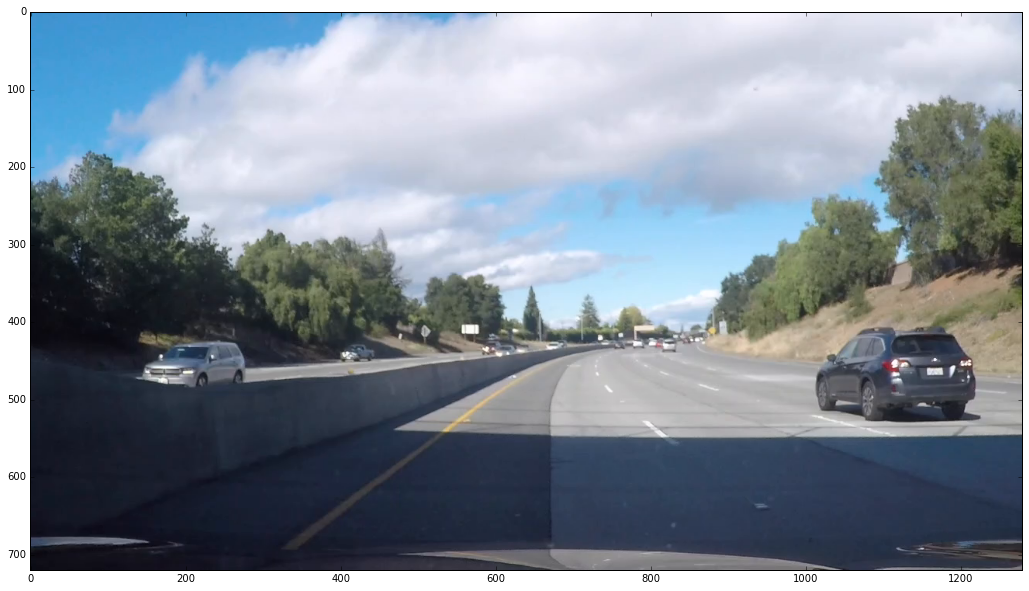

In [136]:
img = challenge_clip.get_frame(5)
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(img)

In [41]:
camera_cal_imgs = [plt.imread(img_path) for img_path in camera_cal_img_paths]
test_imgs = [plt.imread(img_path) for img_path in test_img_paths]
extra_test_imgs = [clip1.get_frame(np.random.randint(0, 30)) for i in range(8)] 

In [240]:
## CAMERA CALIBRATE
# Loop through images find the imgpoints
nx = 9
ny = 6
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

objpoints = []
imgpoints = []
for img in camera_cal_imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        objpoints.append(objp)
        imgpoints.append(corners)


In [17]:
# camera calibration
ret, mtx, dist, rvess, tvess = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


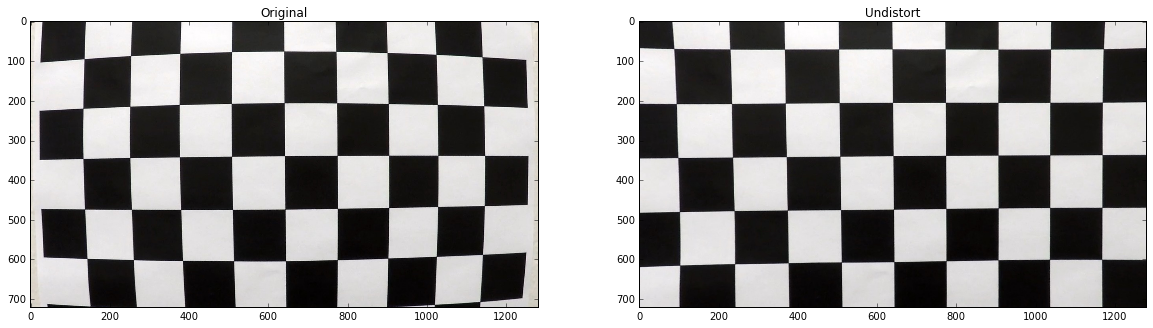

In [244]:
b

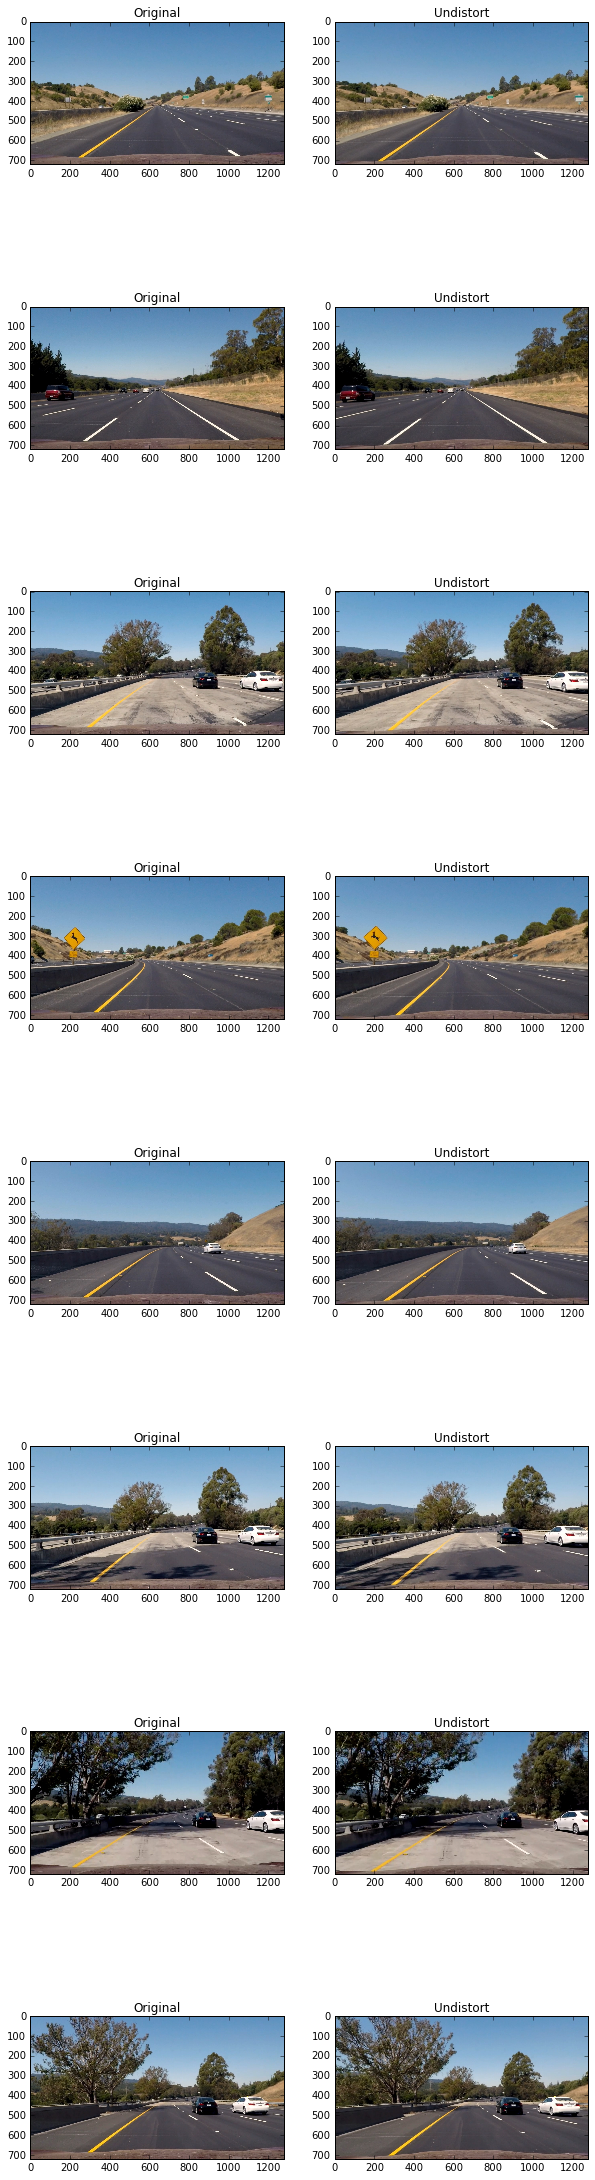

In [18]:
fig, axes = plt.subplots(8, 2, figsize=(10, 40))
undist_imgs = []
for i, img in enumerate(test_imgs):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_imgs.append(undist)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Original')
    axes[i, 1].imshow(undist)
    axes[i, 1].set_title('Undistort')

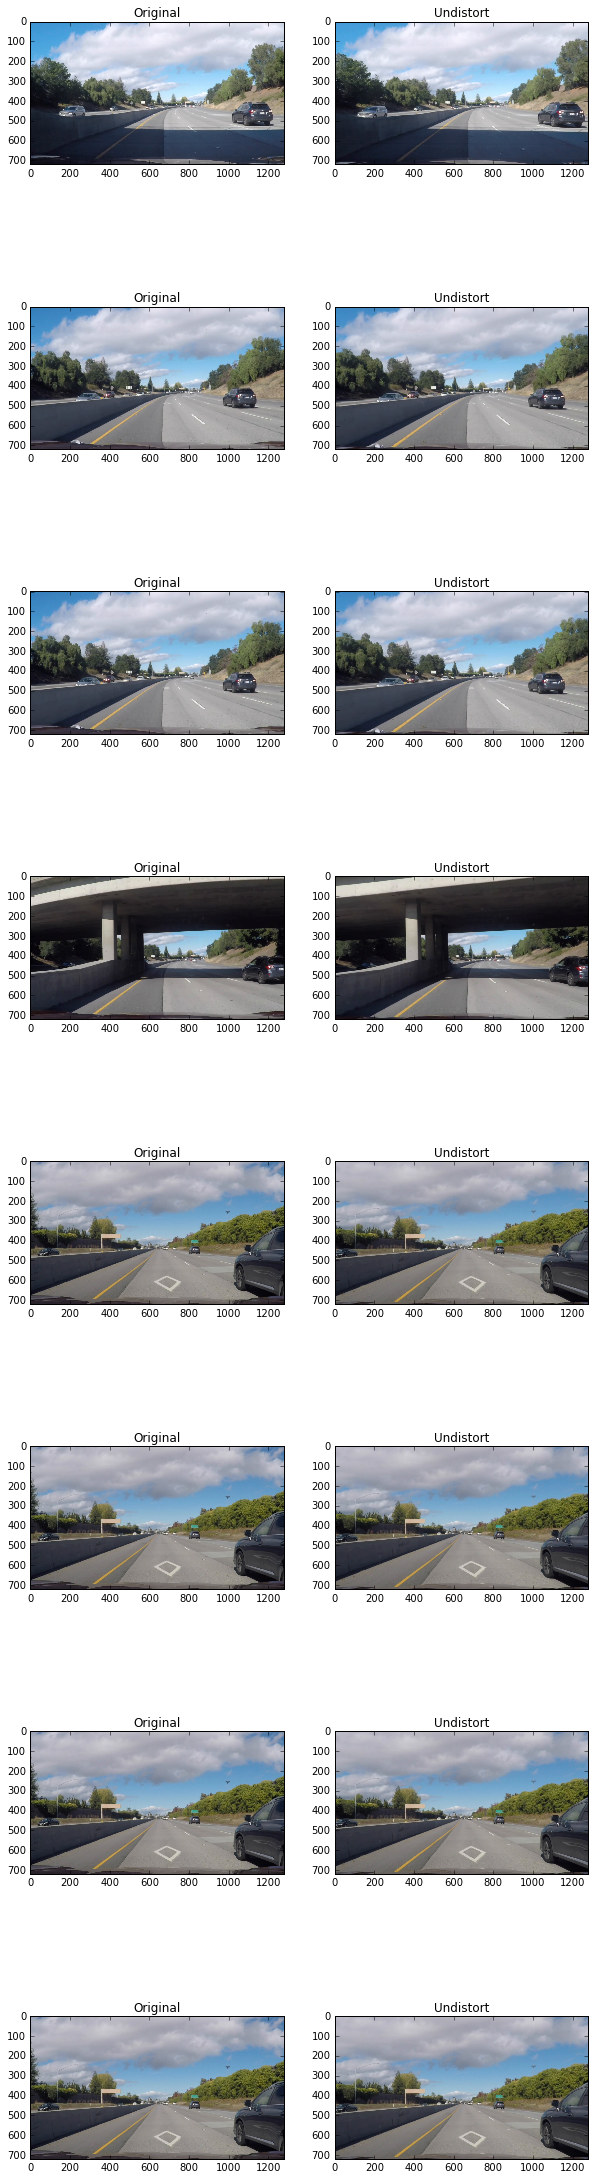

In [239]:
fig, axes = plt.subplots(8, 2, figsize=(10, 40))
undist_extra_imgs = []
for i, img in enumerate(extra_test_imgs):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_extra_imgs.append(undist)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Original')
    axes[i, 1].imshow(undist)
    axes[i, 1].set_title('Undistort')
fig.savefig('undist.jpg')

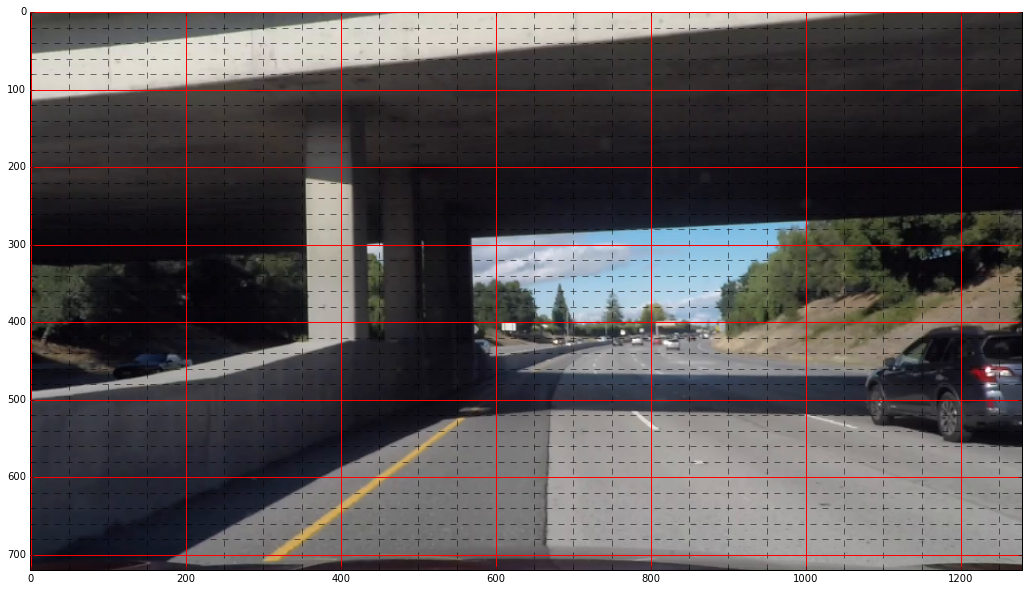

In [43]:
## PERSPECTIVE TRANSFORM

img = undist_extra_imgs[3]

plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(img)
plt.minorticks_on()
plt.grid(which = 'minor', color = 'black', linestyle='--', linewidth=0.5)
plt.grid( color = 'red', linestyle='-', linewidth=1)

In [186]:
src = np.float32([[570, 467],
                  [206, 720], 
                  [715, 467],
                  [1100, 720]])
dest = np.float32([[320, 100],
                   [320, 720],
                   [968, 100],
                   [968, 720]])

In [187]:
M = cv2.getPerspectiveTransform(src, dest)
M_inv = cv2.getPerspectiveTransform(dest, src)
wraped = cv2.warpPerspective(img, M, img.shape[1::-1], flags = cv2.INTER_LINEAR)

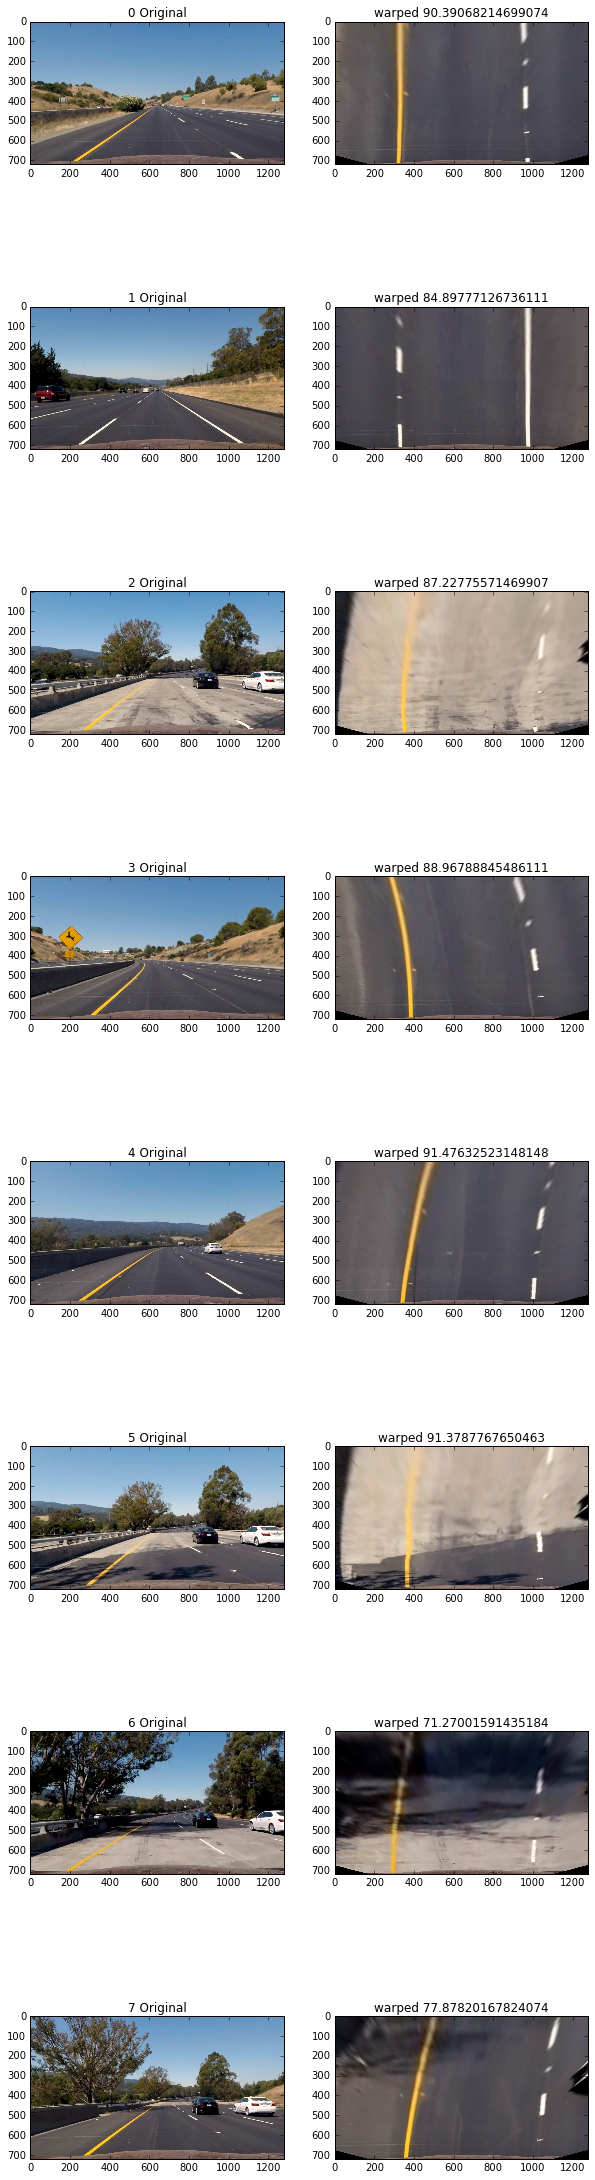

In [238]:
fig, axes = plt.subplots(8, 2, figsize=(10, 40))
warpeds = []
for i, img in enumerate(undist_imgs):
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags = cv2.INTER_LINEAR)
    warpeds.append(warped)
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    mean_brightness = np.mean(HLS[:, :, :])
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(str(i) + ' Original')
    axes[i, 1].imshow(warped)
    axes[i, 1].set_title('warped ' + str(mean_brightness))
fig.savefig('./warped.jpg')

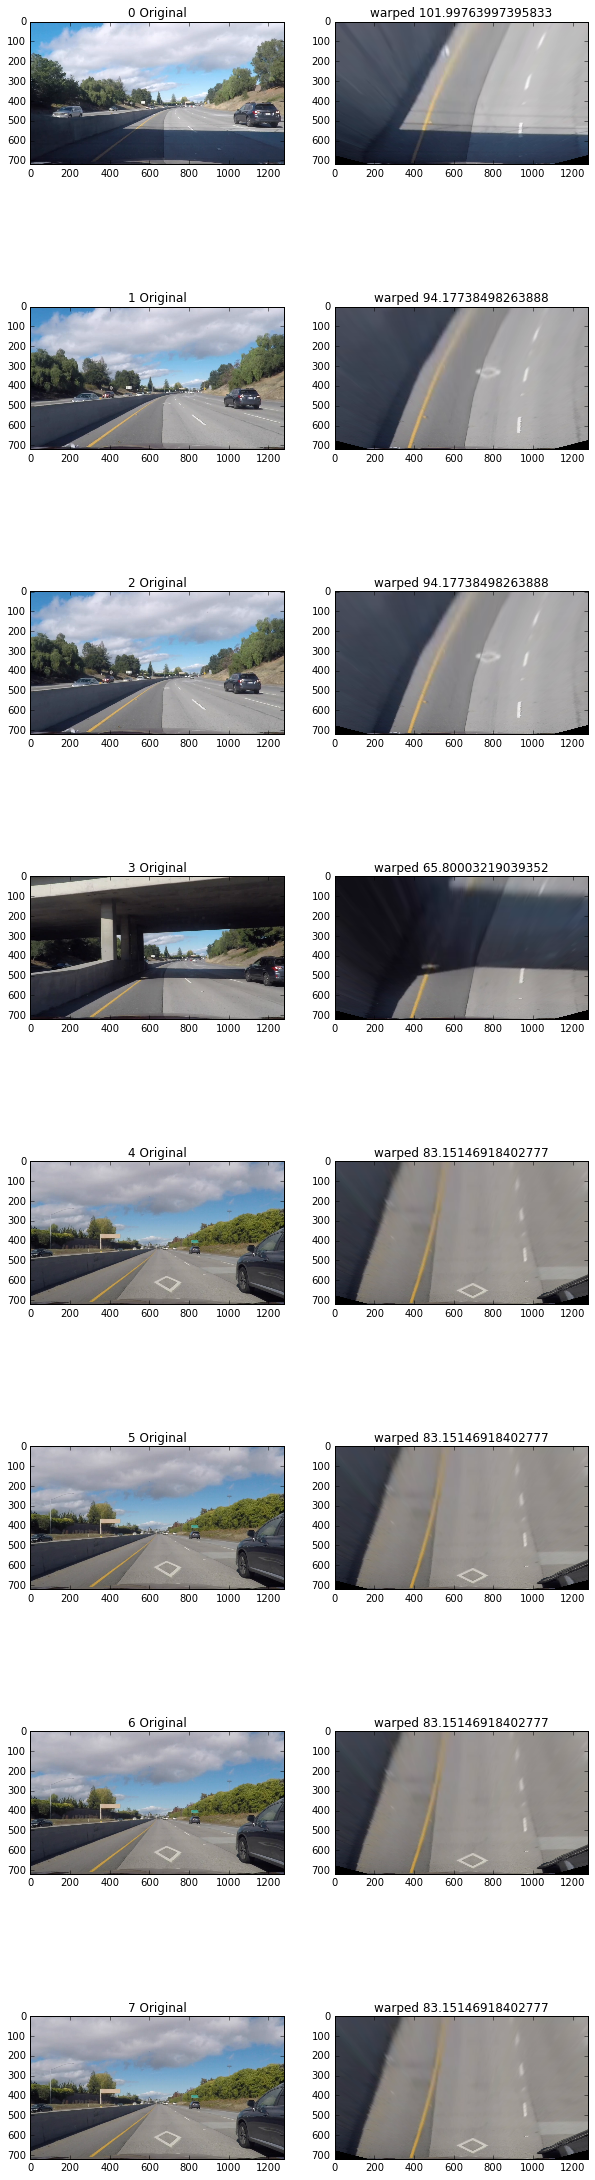

In [236]:
fig, axes = plt.subplots(8, 2, figsize=(10, 40))
warpeds = []
for i, img in enumerate(undist_extra_imgs):
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags = cv2.INTER_LINEAR)
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    mean_brightness = np.mean(HLS[:, :, :])
    warpeds.append(warped)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(str(i) + ' Original')
    axes[i, 1].imshow(warped)
    axes[i, 1].set_title('warped ' + str(mean_brightness))

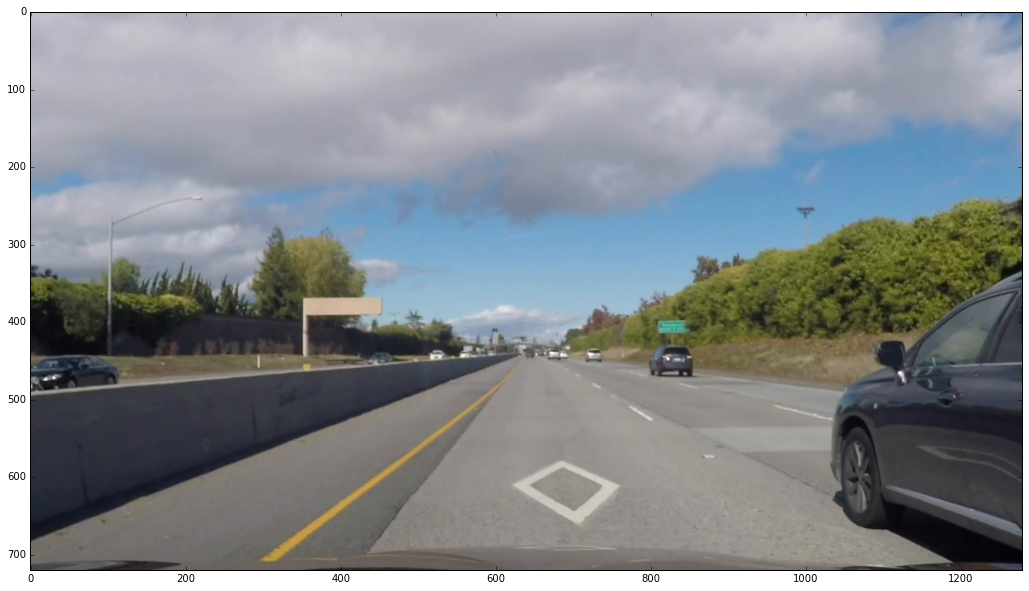

In [214]:
## THRESHOLDING

img = undist_extra_imgs[5]
plt.imshow(img)

In [215]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
l_channel = hls[:, :, 1]
s_channel = hls[:, :, 2]
r_channel = img[:, :, 0]
g_channel = img[:, :, 1]

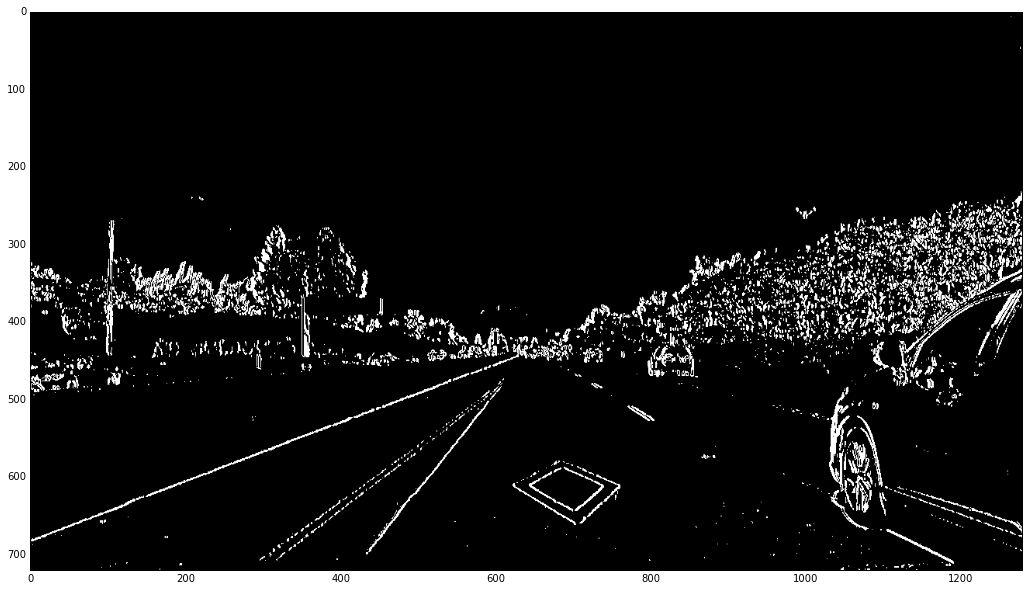

In [216]:
sx_thres = [20, 100]
sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobelx)
scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
sxbinary = np.zeros_like(l_channel)
sxbinary[(scaled_sobel >= sx_thres[0]) & (scaled_sobel < sx_thres[1])] = 1
plt.imshow(sxbinary, cmap = 'gray')

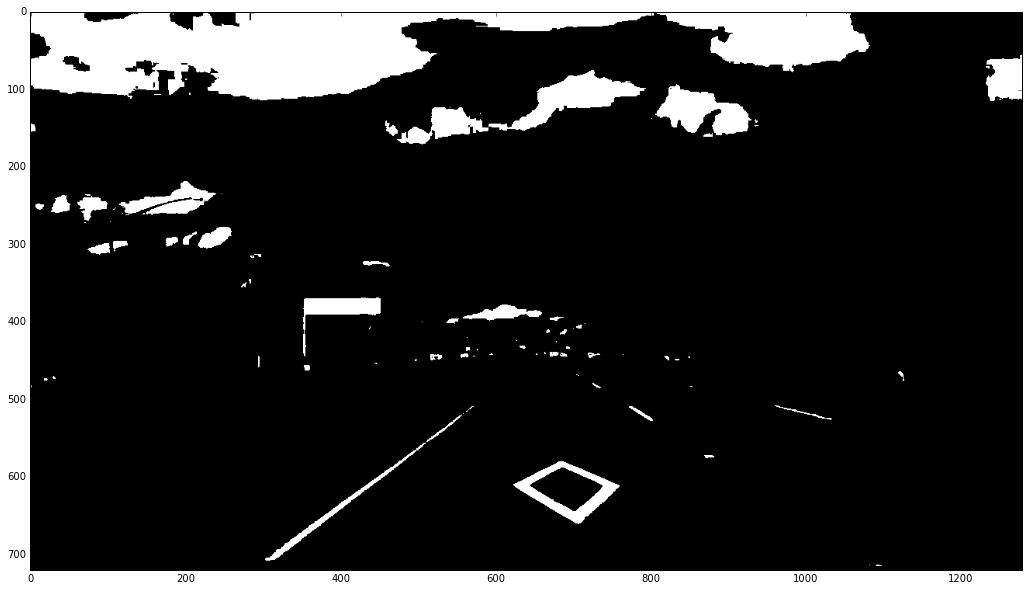

In [217]:
r_thres = [180,255]
r_binary = np.zeros_like(l_channel)
r_binary[(r_channel >= r_thres[0]) & (r_channel < r_thres[1])] = 1
plt.imshow(r_binary, cmap = 'gray')

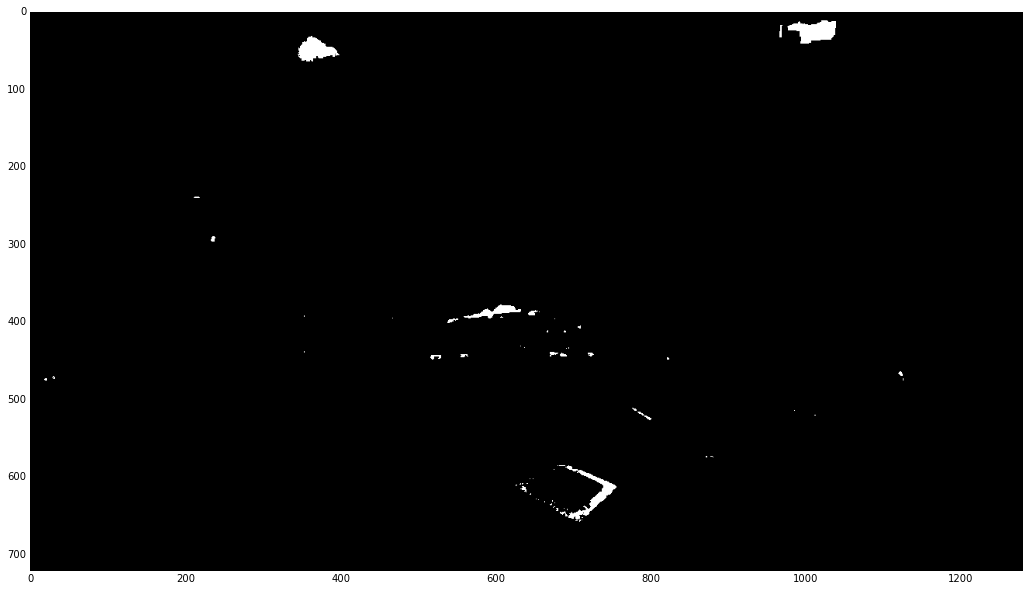

In [218]:
g_thres = [200,255]
g_binary = np.zeros_like(l_channel)
g_binary[(g_channel >= g_thres[0]) & (g_channel < g_thres[1])] = 1
plt.imshow(g_binary, cmap = 'gray')

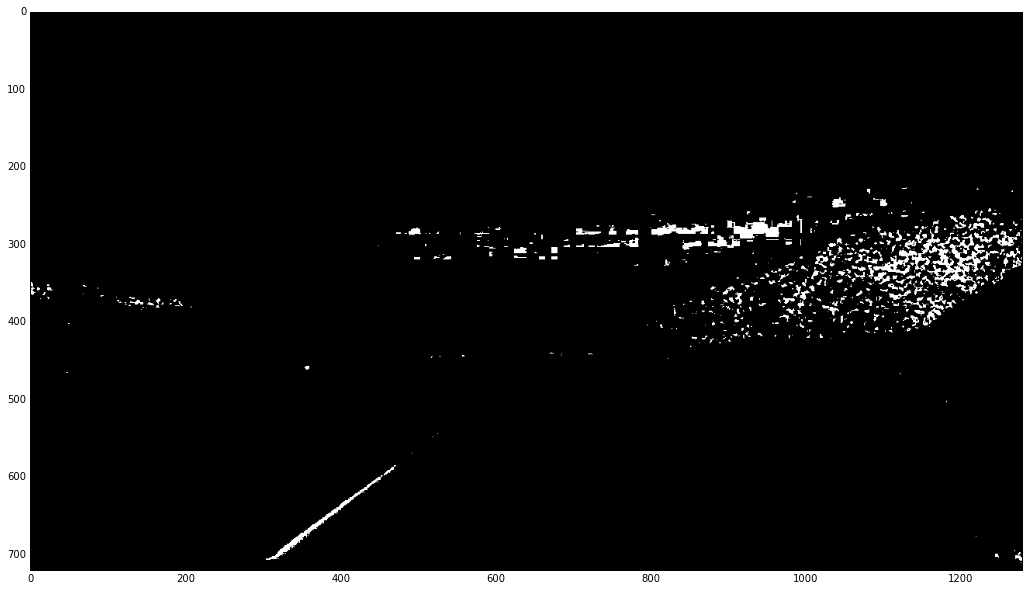

In [219]:
s_thres = [120,255]
s_binary = np.zeros_like(l_channel)
s_binary[(s_channel >= s_thres[0]) & (s_channel < s_thres[1])] = 1
plt.imshow(s_binary, cmap = 'gray')

In [220]:
np.mean(l_channel)

130.5441037326389

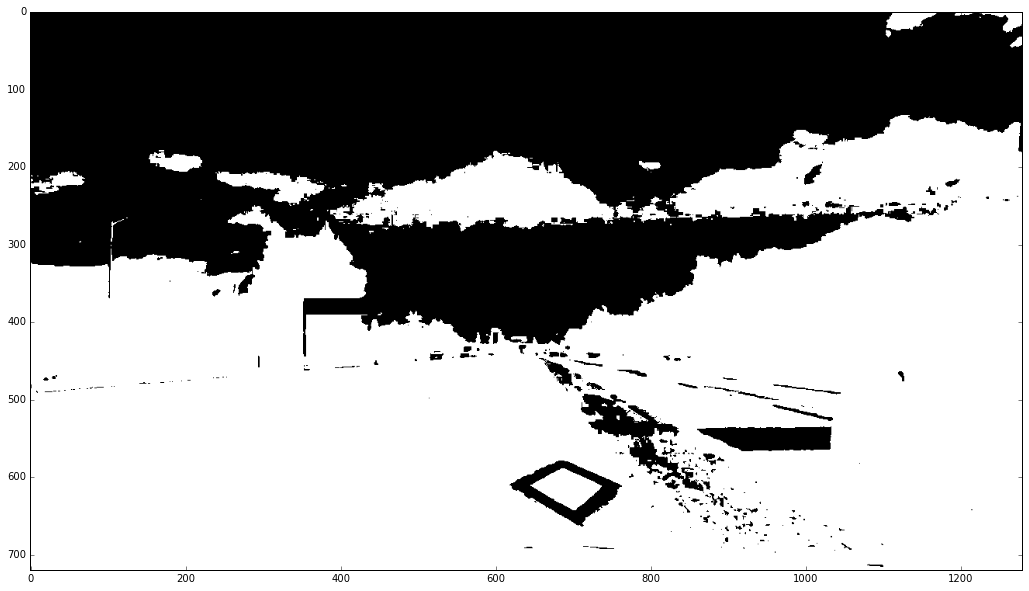

In [221]:
l_thres = [0, 155]
l_binary_shadow = np.zeros_like(l_channel)
l_binary_shadow[(l_channel >= l_thres[0]) & (l_channel < l_thres[1])] = 1
plt.imshow(l_binary_shadow, cmap = 'gray')

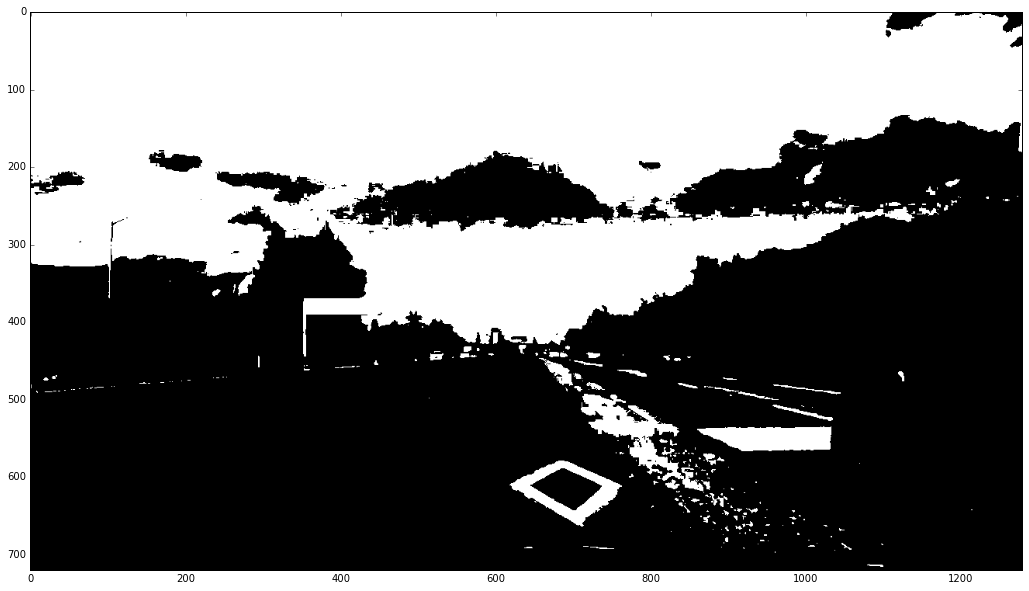

In [222]:
l_thres = [155, 255]
l_binary = np.zeros_like(l_channel)
l_binary[(l_channel >= l_thres[0]) & (l_channel < l_thres[1])] = 1
plt.imshow(l_binary, cmap = 'gray')

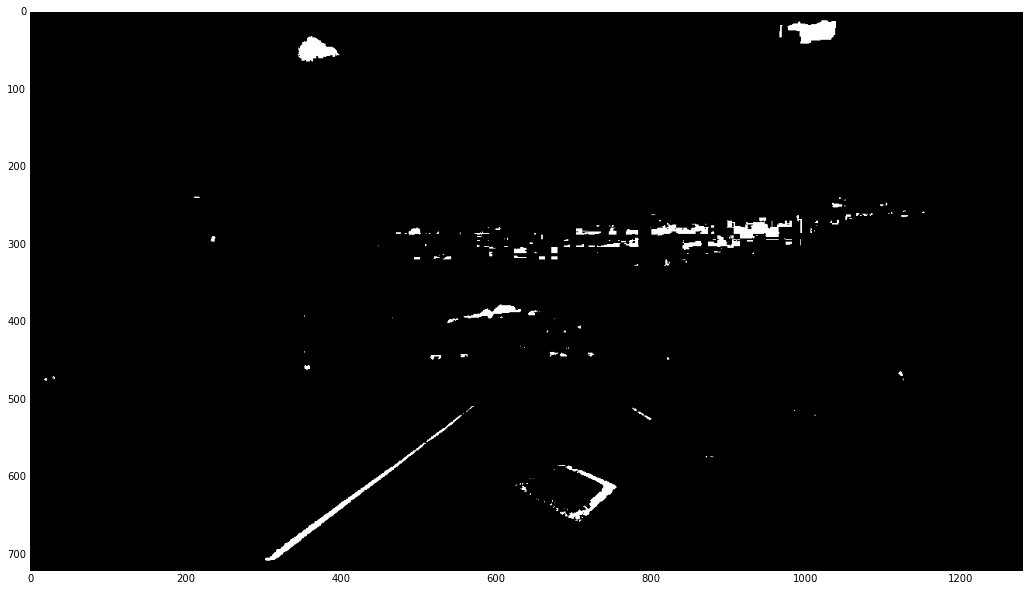

In [223]:
combined_binary = np.zeros_like(l_channel)
combined_binary[(((s_binary == 1) & (l_binary == 1)) | ((r_binary == 1) & (l_binary_shadow == 1)) | (g_binary == 1))] = 1
plt.imshow(combined_binary, cmap = 'gray')

In [224]:
warped = cv2.warpPerspective(combined_binary, M, img.shape[1::-1], flags = cv2.INTER_LINEAR)

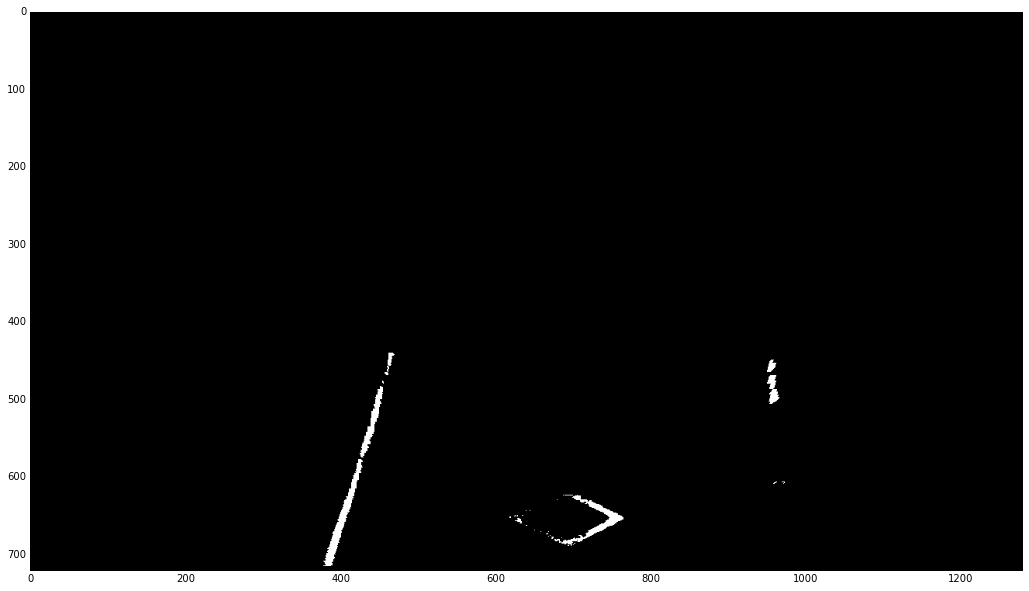

In [225]:
plt.imshow(warped, cmap = 'gray')

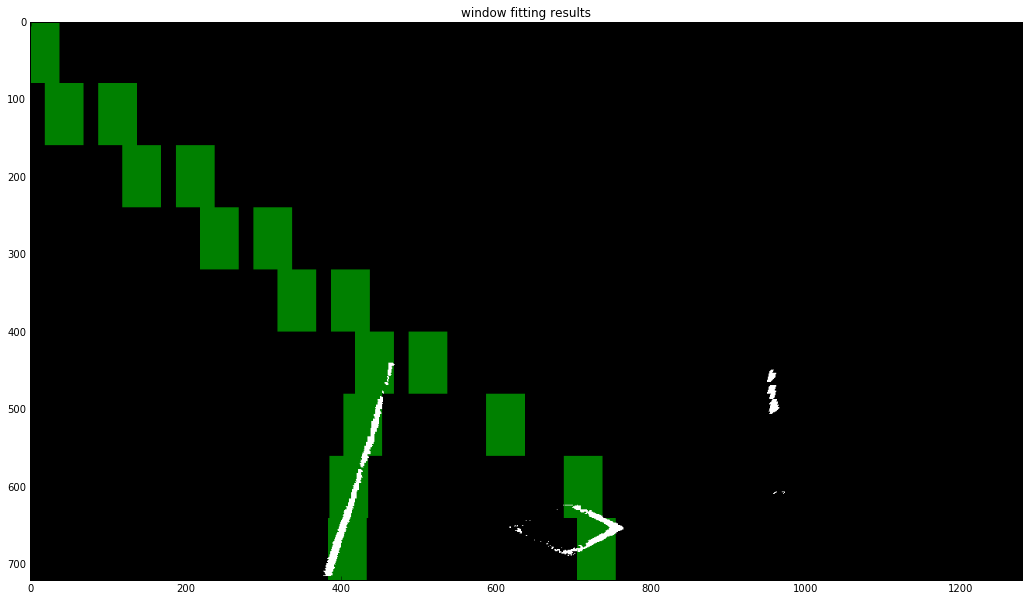

In [228]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    
    left_pixels = ((warped == 1) & (l_points == 255))
    leftx = left_pixels.nonzero()[1]
    lefty = left_pixels.nonzero()[0]
    
    right_pixels = ((warped == 1) & (r_points == 255))
    rightx = right_pixels.nonzero()[1]
    righty = right_pixels.nonzero()[0]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


(720, 0)

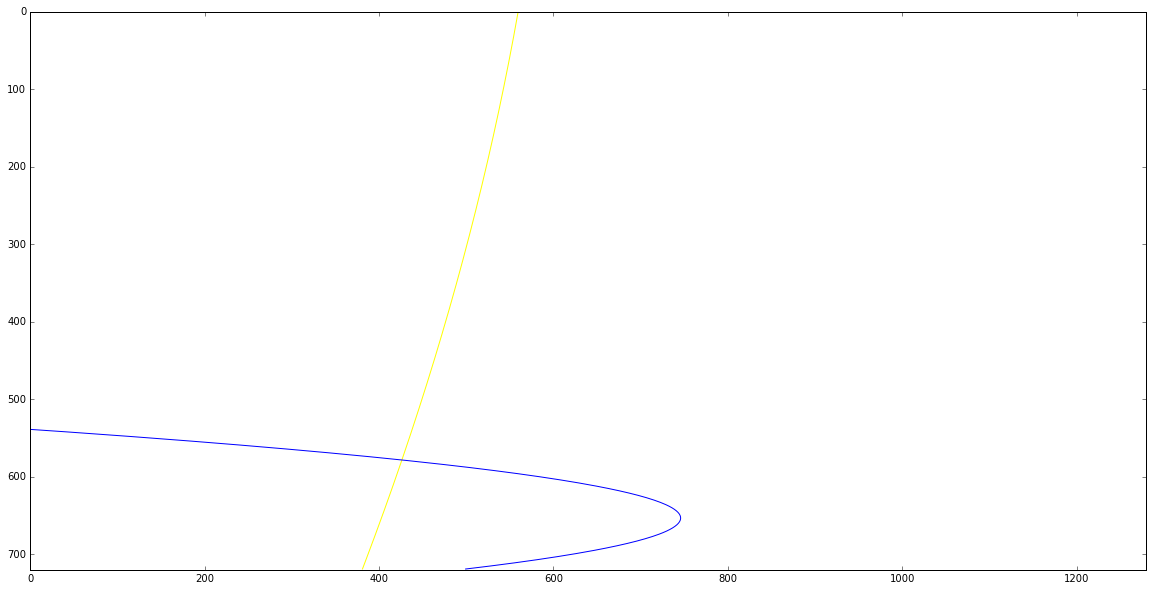

In [229]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='blue')
plt.xlim(0, 1280)
plt.ylim(720, 0)

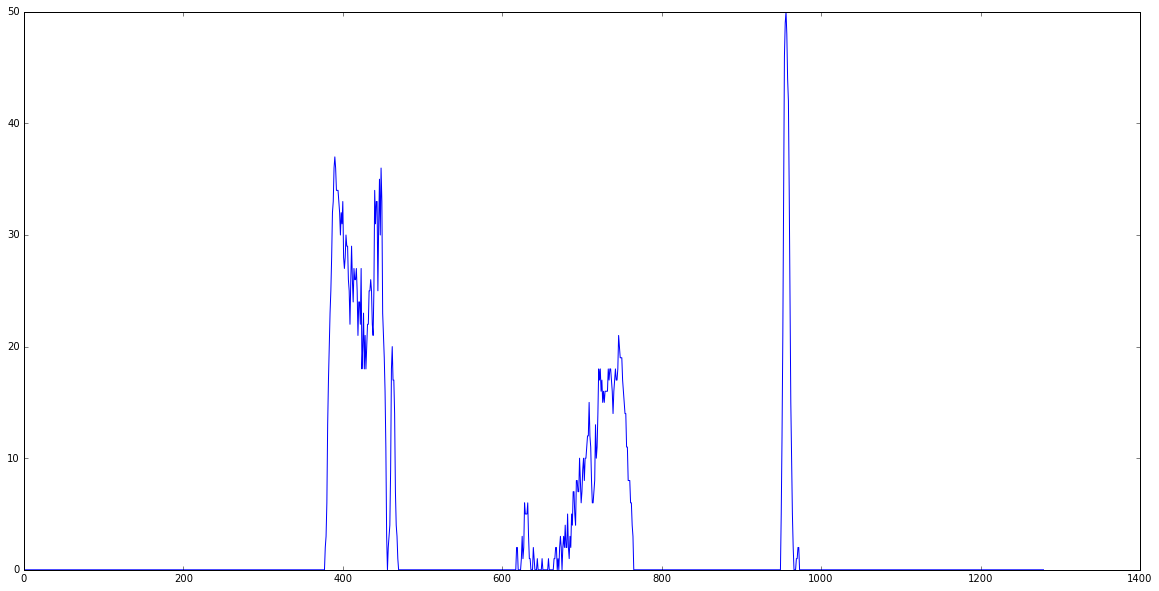

In [230]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
binary_warped = warped

In [231]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 75
# Set minimum number of pixels found to recenter window
minpix = 100
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

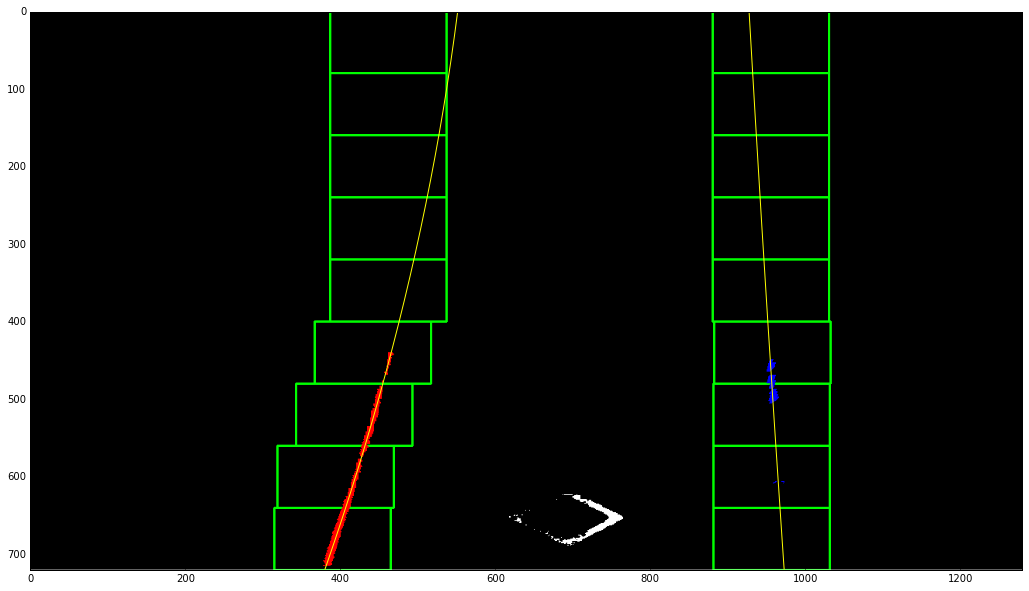

In [232]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [233]:
coef_diff = left_fit[:-1] - right_fit[:-1]
np.linalg.norm(coef_diff, 2) / (np.linalg.norm(left_fit[:-1], 2) + np.linalg.norm(right_fit[:-1],2)) 

0.9999998769441841

In [234]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 75
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

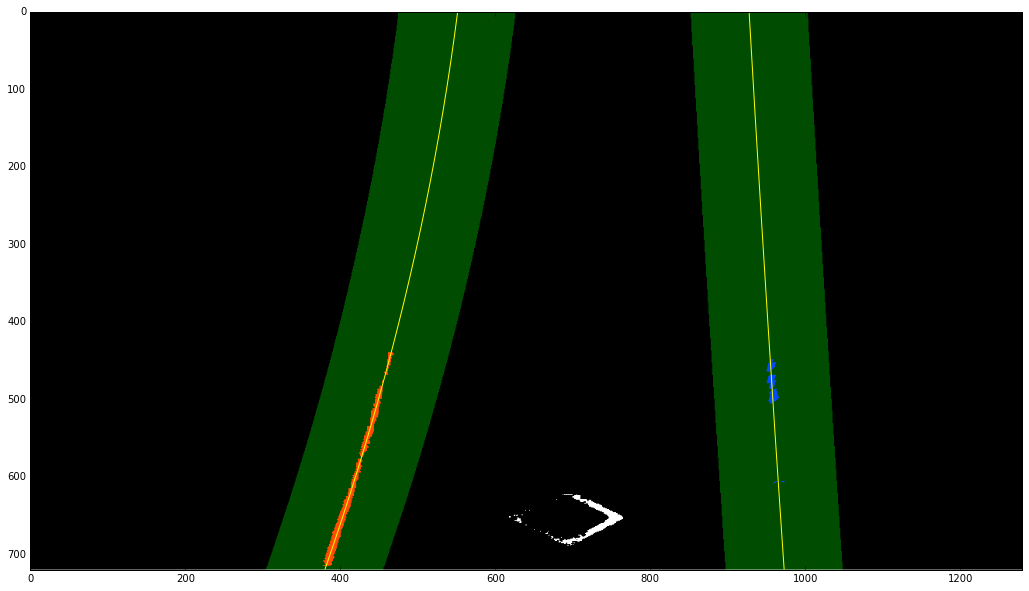

In [235]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
# Create an image to draw on and an image to show the selection window
out_img = cv2.warpPerspective(img, M, img.shape[1::-1], flags = cv2.INTER_LINEAR)
window_img = np.zeros_like(out_img)

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/800 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

In [ ]:
lane_center = (right_fit_cr[2] - left_fit_cr[2]) / 2 + left_fit_cr[2] 

In [ ]:
vehicle_center = (1280 * 3.7 / 800) / 2

In [ ]:
vehicle_center - lane_center

In [ ]:
text1 = 'Left curverad: {0:.0f}(m), Right curverad: {1:.0f}(m)'.format(
    left_curverad, right_curverad)
text2 = 'Vehicle is meter left to the center'


In [ ]:
result_wtext = result.copy()
font = cv2.FONT_HERSHEY_SIMPLEX
plt.imshow(cv2.putText(result_wtext,text1,(100,100), font, 1,(255,255,255),2,cv2.LINE_AA))

In [ ]:
plt.imshow(cv2.putText(result_wtext,text2,(100,150), font, 1,(255,255,255),2,cv2.LINE_AA))

In [ ]:
img = clip1.get_frame(2)
plt.rcParams["figure.figsize"] = (20,10)

In [ ]:
from collections import deque
d = deque(maxlen = 3)

In [ ]:
for i in range(3):
    print(np.random.uniform(0, 10, 3))
    d.append(np.random.uniform(0, 10, 4))

In [ ]:
np.mean(np.array(list(d)), axis = 0)

In [ ]:
clip1.fps